## 1. Warping image using affine and perspective transformations

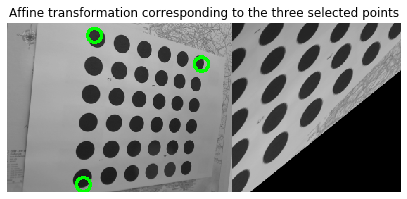

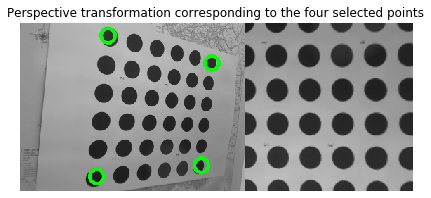

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/circlesgrid.png', cv2.IMREAD_COLOR)
show_img = np.copy(img)

selected_pts = []

def mouse_callback(event, x, y, flags, param):
    global selected_pts, show_img

    if event == cv2.EVENT_LBUTTONUP:
        selected_pts.append([x, y])
        cv2.circle(show_img, (x, y), 10, (0, 255, 0), 3)

def select_points(image, points_num):
    global selected_pts
    selected_pts = []
    
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', mouse_callback)

    while True:
        cv2.imshow('image', image)

        k = cv2.waitKey(1)

        if k == 27 or len(selected_pts) == points_num:
            break

    cv2.destroyAllWindows()

    return np.array(selected_pts, dtype=np.float32)

show_img = np.copy(img)
src_pts = select_points(show_img, 3)
dst_pts = np.array([[0, 240], [0, 0], [240, 0]], dtype=np.float32)

affine_m = cv2.getAffineTransform(src_pts, dst_pts)

unwarped_img = cv2.warpAffine(img, affine_m, (240, 240))

plt.figure(figsize=(6.3,6.3))
plt.axis('off')
plt.title('Affine transformation corresponding to the three selected points')
plt.xticks([]), plt.yticks([])
plt.imshow(np.hstack((show_img, unwarped_img)), cmap='gray')
plt.tight_layout()
plt.show()

inv_affine = cv2.invertAffineTransform(affine_m)
warped_img = cv2.warpAffine(unwarped_img, inv_affine, (320, 240))

cv2.imshow('result', np.hstack((show_img, unwarped_img, warped_img)))
cv2.waitKey()
cv2.destroyAllWindows()

rotation_mat = cv2.getRotationMatrix2D(tuple(src_pts[0]), 6, 1)

rotated_img = cv2.warpAffine(img, rotation_mat, (240, 240))

cv2.imshow('result', np.hstack((show_img, rotated_img)))
cv2.waitKey()
cv2.destroyAllWindows()

show_img = np.copy(img)
src_pts = select_points(show_img, 4)
dst_pts = np.array([[0, 240], [0, 0], [240, 0], [240, 240]], dtype=np.float32)

perspective_m = cv2.getPerspectiveTransform(src_pts, dst_pts)

unwarped_img = cv2.warpPerspective(img, perspective_m, (240, 240))

plt.figure(figsize=(6.5,6.5))
plt.axis('off')
plt.title('Perspective transformation corresponding to the four selected points')
plt.xticks([]), plt.yticks([])
plt.imshow(np.hstack((show_img, unwarped_img)), cmap='gray')
plt.tight_layout()
plt.show()

## 2. Remapping image using arbitrary transformation 

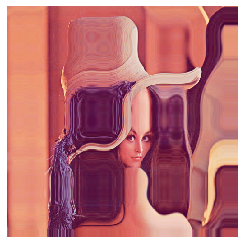

In [2]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/Lena.png')

xmap = np.zeros((img.shape[1], img.shape[0]), np.float32)
ymap = np.zeros((img.shape[1], img.shape[0]), np.float32)
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        xmap[y,x] = x + 30 * math.cos(20 * x / img.shape[0])
        ymap[y,x] = y + 30 * math.sin(20 * y / img.shape[1])
        
remapped_img = cv2.remap(img, xmap, ymap, cv2.INTER_LINEAR, None, cv2.BORDER_REPLICATE)

plt.figure(figsize=(3.5,3.5))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.imshow(remapped_img[:,:,[2,1,0]])
plt.tight_layout()
plt.show()

## 3. Tracking keypoints between frames using Lucas-Kanade algorithm

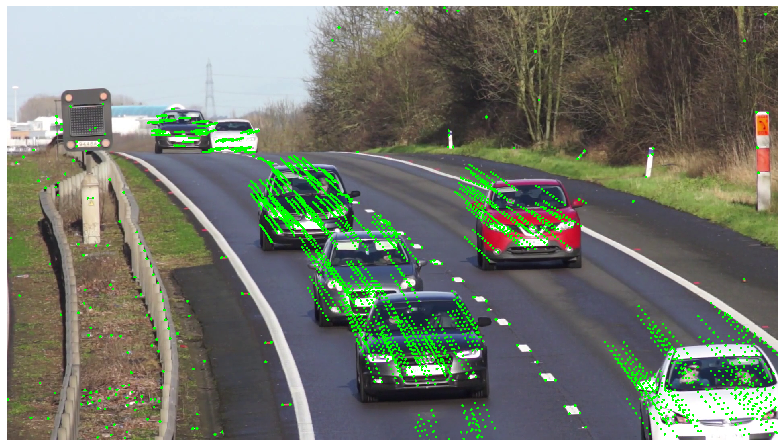

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step1: Initialize
video = cv2.VideoCapture('./data/traffic.mp4')
prev_pts = None
prev_gray_frame = None
tracks = None

# Step2: Get frame and convert it to grayscale
while True:
    retval, frame = video.read()
    if not retval: break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Step3: Use Sparse Lucas-Kanade optical flow algorithm to track keypoints.    
    if prev_pts is not None:
        pts, status, errors = cv2.calcOpticalFlowPyrLK(
            prev_gray_frame, gray_frame, prev_pts, None, winSize=(15,15), maxLevel=5,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        good_pts = pts[status == 1]
        if tracks is None:
            tracks = good_pts
        else:
            tracks = np.vstack((tracks, good_pts))
        for p in tracks:
            cv2.circle(frame, (p[0], p[1]), 3, (0, 255, 0), -1)
    else:
        pts = cv2.goodFeaturesToTrack(gray_frame, 500, 0.05, 10)
        pts = pts.reshape(-1, 1, 2)
    
    # Step4: Remember the current point position and the current frame.
    prev_pts = pts
    prev_gray_frame = gray_frame
    
    cv2.imshow('frame', frame)
    key = cv2.waitKey() & 0xff
    if key == 27: #ESC
        break
    if key == ord('c'): #C: initialize
        tracks = None
        prev_pts = None
        
cv2.destroyAllWindows()
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(11,11))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 4. Background subtraction

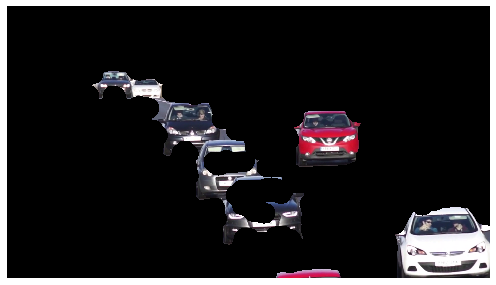

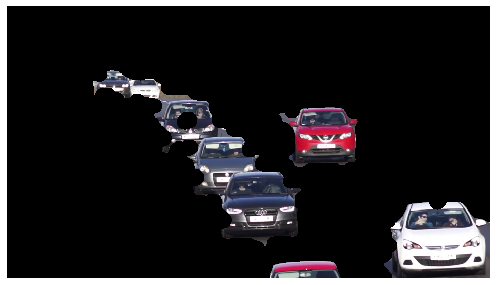

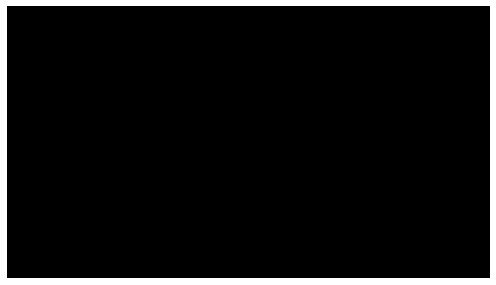

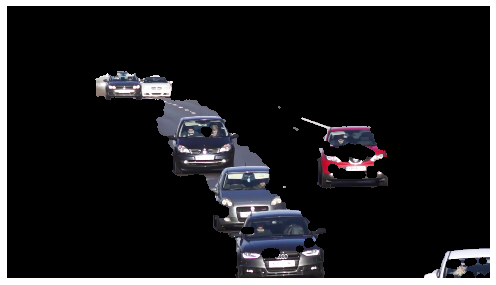

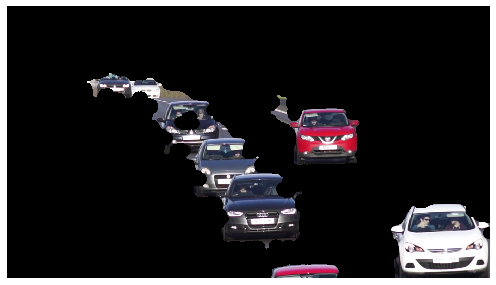

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Background Subtraction Algorithm
def split_image_fgbg(subtractor, open_sz=(0,0), close_sz=(0,0), show_bg=False, show_shdw=False):
    kernel_open = kernel_close = None
    
    if all(i > 0 for i in open_sz):
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, open_sz)
    
    if all(i > 0 for i in close_sz):
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, close_sz)

    cap = cv2.VideoCapture('./data/traffic.mp4')
    while True:
        status_cap, frame = cap.read()
        if not status_cap:
            break
        
        frame = cv2.resize(frame, None, fx=0.5, fy=0.5)
        
        fgmask = subtractor.apply(frame)
        
        objects_mask = (fgmask == 255).astype(np.uint8)
        shadows_mask = (fgmask == 127).astype(np.uint8)
            
        if kernel_open is not None:
            objects_mask = cv2.morphologyEx(objects_mask, cv2.MORPH_OPEN, kernel_open)

        if kernel_close is not None:
            objects_mask = cv2.morphologyEx(objects_mask, cv2.MORPH_CLOSE, kernel_close)
            if kernel_open is not None:
                shadows_mask = cv2.morphologyEx(shadows_mask, cv2.MORPH_CLOSE, kernel_open)
                         
        foreground = frame
        foreground[objects_mask == 0] = 0
        
        if show_shdw:
            foreground[shadows_mask > 0] = (0, 255, 0)
               
        cv2.imshow('foreground', foreground)

        if show_bg:
            background = fgbg.getBackgroundImage()
            if background is not None:
                cv2.imshow('background', background)    

        if cv2.waitKey(30) == 27: #ESC
            break

    cap.release()
    cv2.destroyAllWindows()
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(image)
    plt.show()

# 1.Gaussian Mixture based background segmentation algorithm
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
split_image_fgbg(fgbg, (2, 2), (40, 40))

# 2.Advanced version of above one
fgbg = cv2.createBackgroundSubtractorMOG2()
split_image_fgbg(fgbg, (3, 3), (30, 30), True)

# 3.Background subtraction algo of Godbehere/Matsukawa/Goldberg to make a background mask
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()
split_image_fgbg(fgbg, (5, 5), (25, 25))

# 4.Calculation based back sub algo by Sagi Zeevi
fgbg = cv2.bgsegm.createBackgroundSubtractorCNT()
split_image_fgbg(fgbg, (5, 5), (15, 15), True)

# 5.Background segmentation method based on Nearest Neighbors function
fgbg = cv2.createBackgroundSubtractorKNN()
split_image_fgbg(fgbg, (5, 5), (25, 25), True)

## 5. Stitching many images into panorama

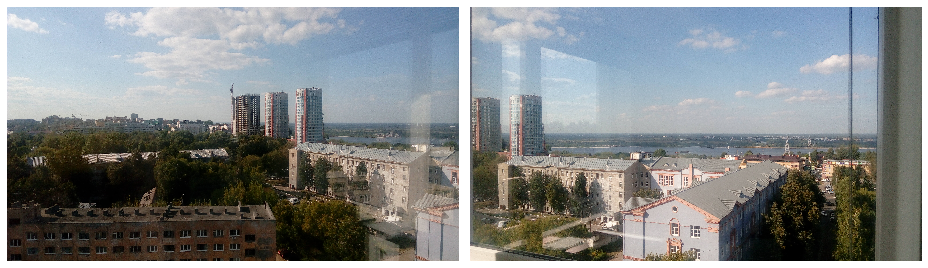

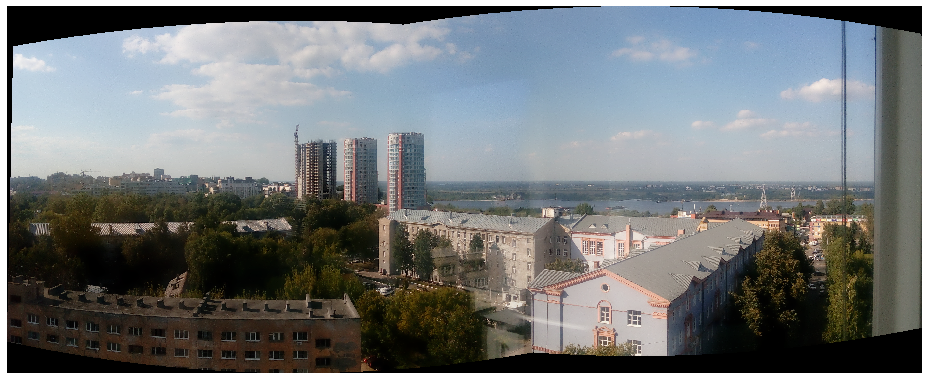

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

images = []
images.append(cv2.imread('./data/panorama/0.jpg', cv2.IMREAD_COLOR))
images.append(cv2.imread('./data/panorama/1.jpg', cv2.IMREAD_COLOR))

plt.figure(figsize=(13,6.5))
plt.subplot(121)
image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.imshow(image)
plt.subplot(122)
image = cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.imshow(image)
plt.tight_layout()
plt.show()

stitcher = cv2.createStitcher()
ret, pano = stitcher.stitch(images)

if ret == cv2.STITCHER_OK:
    #cv2.imshow('panorama', pano)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    image = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(13,13))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(image)
    plt.show()
else:
    print('Error during stiching')

## 6. Denoising photo using non-local means algorithm

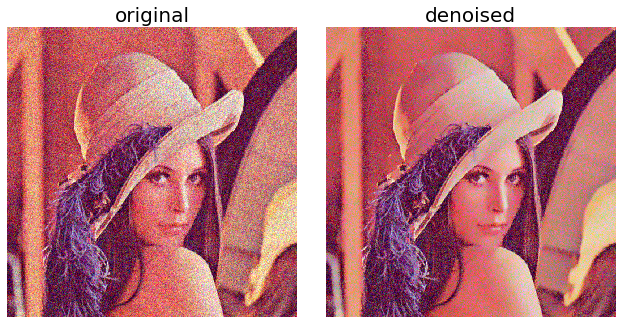

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/Lena.png')

# Random Gaussian Noise
noise = 30 * np.random.randn(*img.shape)
img = np.uint8(np.clip(img + noise, 0, 255))

# non-local means algo
denoised_nlm = cv2.fastNlMeansDenoisingColored(img, None, 10)

plt.figure(0, figsize=(9,4.5))
plt.subplot(121)
plt.axis('off')
plt.title('original', size=20)
plt.xticks([]), plt.yticks([])
plt.imshow(img[:,:,[2,1,0]])
plt.subplot(122)
plt.axis('off')
plt.title('denoised', size=20)
plt.xticks([]), plt.yticks([])
plt.imshow(denoised_nlm[:,:,[2,1,0]])
plt.tight_layout()
plt.show()

## 7. Constructing HDR(High Dynamic Range) image

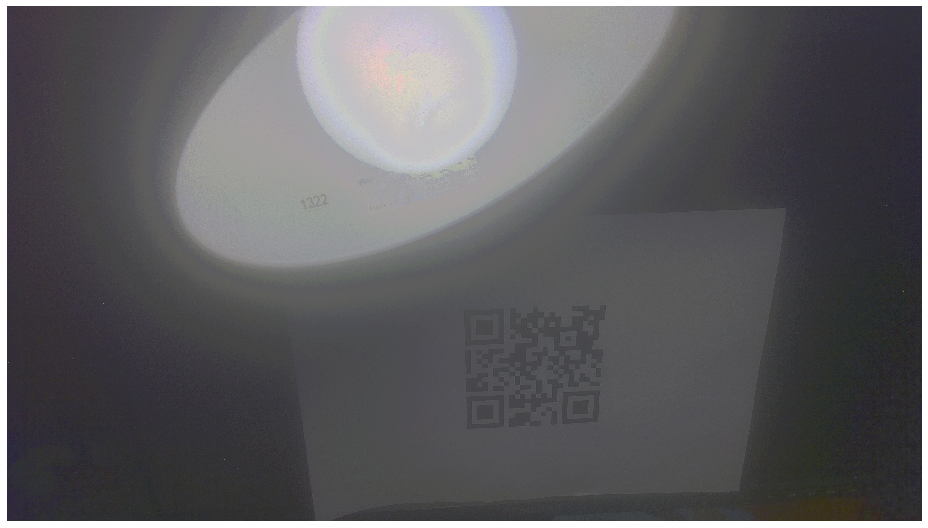

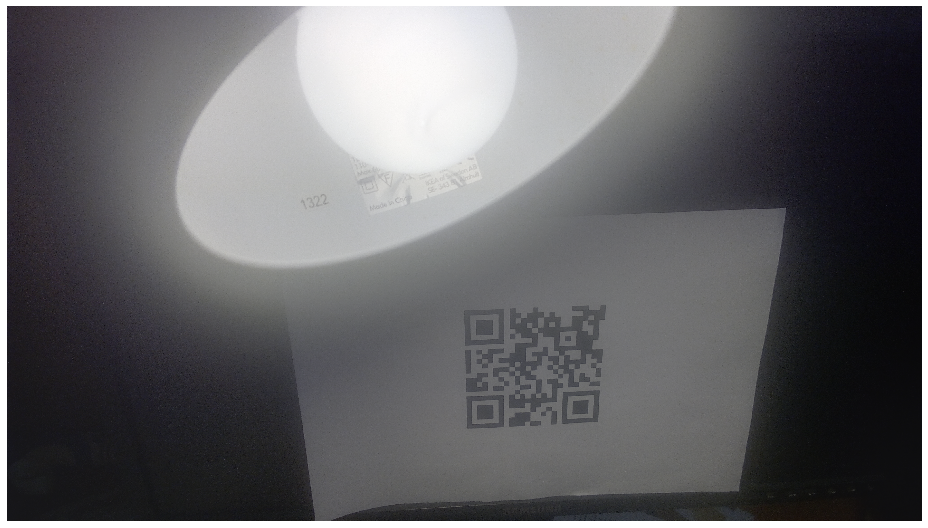

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

imgs_names = ['33', '100', '179', '892', '1560', '2933']

exp_times = []
images = []

for name in imgs_names:
    exp_times.append(1/float(name))
    images.append(cv2.imread('./data/hdr/%s.jpg' % name, cv2.IMREAD_COLOR))

exp_times = np.array(exp_times).astype(np.float32)

calibrate = cv2.createCalibrateDebevec()
response = calibrate.process(images, exp_times)

merge_debevec = cv2.createMergeDebevec()
hdr = merge_debevec.process(images, exp_times, response)

tonemap = cv2.createTonemapDurand(2.4)
ldr = tonemap.process(hdr)

ldr = cv2.normalize(ldr, None, 0, 1, cv2.NORM_MINMAX)

image = cv2.cvtColor(ldr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(13,13))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

merge_mertens = cv2.createMergeMertens()
fusion = merge_mertens.process(images)

fusion = cv2.normalize(fusion, None, 0, 1, cv2.NORM_MINMAX)

image = cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(13,13))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 8. Removing defects from photo with image inpainting

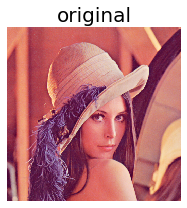

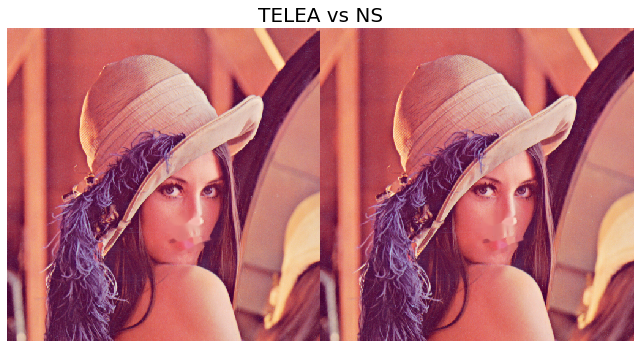

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class MaskCreator:
    def __init__(self, image, mask):
        self.prev_pt = None
        self.image = image
        self.mask = mask
        self.dirty = False
        self.show()
        cv2.setMouseCallback('mask', self.mouse_callback)

    def show(self):
        cv2.imshow('mask', self.image)

    def mouse_callback(self, event, x, y, flags, param):
        pt = (x, y)
        if event == cv2.EVENT_LBUTTONDOWN:
            self.prev_pt = pt
        elif event == cv2.EVENT_LBUTTONUP:
            self.prev_pt = None

        if self.prev_pt and flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.line(self.image, self.prev_pt, pt, (127,)*3, 5)
            cv2.line(self.mask, self.prev_pt, pt, 255, 5)
                
            self.dirty = True
            self.prev_pt = pt
            self.show()
            
img = cv2.imread('./data/Lena.png')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.axis('off')
plt.title('original', size=20)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

defect_img = img.copy()
mask = np.zeros(img.shape[:2], np.uint8)
m_creator = MaskCreator(defect_img, mask)

while True:
    k = cv2.waitKey()
    if k == 27: #ESC
        break
    if k == ord('a'): #A
        res_telea = cv2.inpaint(defect_img, mask, 3, cv2.INPAINT_TELEA)
        res_ns = cv2.inpaint(defect_img, mask, 3, cv2.INPAINT_NS)
        cv2.imshow('TELEA vs NS', np.hstack((res_telea, res_ns)))
    if k == ord('c'): #C
        defect_img[:] = img
        mask[:] = 0
        m_creator.show()
        
cv2.destroyAllWindows()
image = cv2.cvtColor(np.hstack((res_telea, res_ns)), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,9))
plt.axis('off')
plt.title('TELEA vs NS', size=20)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()